In [1]:
# from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
# import torchaudio
import torch.nn as nn
import torch.nn.functional as F
# import torch.optim as optim
# import numpy as np
# import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
# import pandas as pd
# import os

data_path = './data/spectrograms' #looking in subfolder train

In [2]:
multi_dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([transforms.Resize((201,1103)),
                                  transforms.ToTensor()
                                  ])
)
print(multi_dataset)

Dataset ImageFolder
    Number of datapoints: 223
    Root location: ./data/spectrograms
    StandardTransform
Transform: Compose(
               Resize(size=(201, 1103), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [3]:
class_map=multi_dataset.class_to_idx

print("\nClass category and index of the images: {}\n".format(class_map))


Class category and index of the images: {'blender': 0, 'garbage': 1, 'noise': 2}



In [4]:
#split data to test and train
#use 80% to train
train_size = int(0.8 * len(multi_dataset))
test_size = len(multi_dataset) - train_size
multi_train_dataset, multi_test_dataset = torch.utils.data.random_split(multi_dataset, [train_size, test_size])

print("Training size:", len(multi_train_dataset))
print("Testing size:",len(multi_test_dataset))

Training size: 178
Testing size: 45


In [5]:
from collections import Counter

# labels in training set
train_classes = [label for _, label in multi_train_dataset]
Counter(train_classes)

Counter({0: 86, 2: 85, 1: 7})

In [6]:
test_classes = [label for _, label in multi_test_dataset]
Counter(test_classes)

Counter({0: 24, 2: 18, 1: 3})

In [7]:
train_dataloader = torch.utils.data.DataLoader(
    multi_train_dataset,
    batch_size=1,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    multi_test_dataset,
    batch_size=1,
    shuffle=True
)
td = train_dataloader.dataset[0][0][0][0]
print(td)

tensor([0.9059, 0.3922, 0.6784,  ..., 0.5333, 0.6235, 0.2235])


In [8]:
import torch_directml
tensor_dev = torch_directml.device(0)
print('Using {} device'.format(torch_directml.device_name(tensor_dev.index)))

Using AMD Radeon RX 6800M  device


In [9]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(841728, 50)
        self.fc2 = nn.Linear(50, 3)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.sigmoid(x)  

model = CNNet().to(tensor_dev)

In [10]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
CNNet                                    --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Dropout2d: 1-3                         --
├─Flatten: 1-4                           --
├─Linear: 1-5                            42,086,450
├─Linear: 1-6                            153
Total params: 42,105,995
Trainable params: 42,105,995
Non-trainable params: 0

In [11]:
# cost function used to determine best parameters
cost = torch.nn.CrossEntropyLoss()

# used to create optimal parameters
learning_rate = 1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
model.to(tensor_dev)
# Create the training function

def train(dataloader, model, loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):
        
        X, Y = X.to(tensor_dev), Y.to(tensor_dev)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')


# Create the validation/test function

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(tensor_dev), Y.to(tensor_dev)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

In [13]:
epochs = 15

for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train(train_dataloader, model, cost, optimizer)
    test(test_dataloader, model)
print('Done!')

Epoch 1
-------------------------------


loss: 1.108991  [    0/  178]
loss: 1.128301  [  100/  178]

Test Error:
acc: 53.3%, avg loss: 1.031364

Epoch 2
-------------------------------
loss: 1.118871  [    0/  178]
loss: 1.076783  [  100/  178]

Test Error:
acc: 88.9%, avg loss: 0.979459

Epoch 3
-------------------------------
loss: 0.966444  [    0/  178]
loss: 0.970781  [  100/  178]

Test Error:
acc: 91.1%, avg loss: 0.962639

Epoch 4
-------------------------------
loss: 0.926417  [    0/  178]
loss: 0.907138  [  100/  178]

Test Error:
acc: 93.3%, avg loss: 0.953525

Epoch 5
-------------------------------
loss: 0.955539  [    0/  178]
loss: 1.007075  [  100/  178]

Test Error:
acc: 93.3%, avg loss: 0.934498

Epoch 6
-------------------------------
loss: 0.916543  [    0/  178]
loss: 0.951085  [  100/  178]

Test Error:
acc: 93.3%, avg loss: 0.920848

Epoch 7
-------------------------------
loss: 0.969095  [    0/  178]
loss: 0.940387  [  100/  178]

Test Error:
acc: 93.3%, avg loss: 0.900600

Epoch 8
-----------------

In [14]:
model.to(tensor_dev).eval()
class_map = ['blender', 'garbage', 'noise']
correct = 0
with torch.no_grad():
    for batch, (X, Y) in enumerate(test_dataloader):
        X, Y = X.to(tensor_dev), Y.to(tensor_dev)
        pred = model(X)
        print("Predicted:\nvalue={}, class_name= {}\n".format(pred[0].argmax(0),class_map[pred[0].argmax(0)]))
        print("Actual:\nvalue={}, class_name= {}\n".format(Y[0],class_map[Y[0]]))
        correct += 1 if pred[0].argmax(0)==Y[0] else 0
    print('Correct count = {}'.format(correct))
    print('Accuracy = {}'.format(correct/len(test_dataloader)))


Predicted:
value=2, class_name= noise

Actual:
value=2, class_name= noise

Predicted:
value=0, class_name= blender

Actual:
value=0, class_name= blender

Predicted:
value=2, class_name= noise

Actual:
value=2, class_name= noise

Predicted:
value=0, class_name= blender

Actual:
value=0, class_name= blender

Predicted:
value=0, class_name= blender

Actual:
value=0, class_name= blender

Predicted:
value=2, class_name= noise

Actual:
value=2, class_name= noise

Predicted:
value=0, class_name= blender

Actual:
value=0, class_name= blender

Predicted:
value=0, class_name= blender

Actual:
value=0, class_name= blender

Predicted:
value=0, class_name= blender

Actual:
value=0, class_name= blender

Predicted:
value=0, class_name= blender

Actual:
value=0, class_name= blender

Predicted:
value=2, class_name= noise

Actual:
value=2, class_name= noise

Predicted:
value=2, class_name= noise

Actual:
value=2, class_name= noise

Predicted:
value=0, class_name= blender

Actual:
value=0, class_name= bl

In [15]:
from torchviz import make_dot

y = model(X).to(tensor_dev)

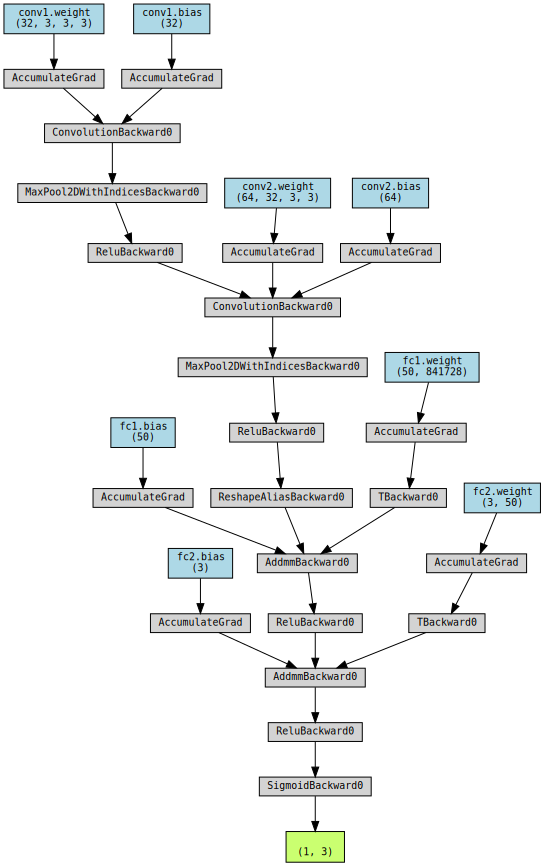

In [16]:
make_dot(y, params=dict(model.named_parameters()))